---------
- # 요약
    - ## 소프트맥스 분류
        - scatter
        - randint
        - rand
        - unsqueeze
        - log-softmax
        - nll_loss
        - cross_entropy
----

# 소프트맥스 분류
- 입력을 특정 클래스로 분류하는 문제임
- 출력값은 해당 클래스의 확률 형태로 출력됨
- 토치를 통해 수식을 구현할 떄는 괄호의 안쪽부터 바깥쪽으로 함수를 통해 표현되기 때문에 유의할 것


## Low-Level

In [ ]:
z = torch.rand(3, 5, requires_grad=True)
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [ ]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


In [ ]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

- 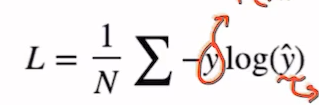

- 크로스엔트로피 구현 코드임

In [ ]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


## nn.functional


### 순전파

In [ ]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [ ]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

### 손실함수 계산

In [ ]:
# Low level
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [ ]:
# High level
# Negative log likelihood
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [ ]:
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

# 전체 코드

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

## F.cross_entropy
- cross_entropy 입력 값 유의

In [4]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (2)
    z = x_train.matmul(W) + b # or .mm or @
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


## High-level Implementation with `nn.Module`
- Linear 레이어의 출력 값 유의

In [5]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

In [6]:
model = SoftmaxClassifierModel()

Let's try another new dataset.

In [7]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 2.931173
Epoch  100/1000 Cost: 0.717869
Epoch  200/1000 Cost: 0.636483
Epoch  300/1000 Cost: 0.578341
Epoch  400/1000 Cost: 0.527309
Epoch  500/1000 Cost: 0.479276
Epoch  600/1000 Cost: 0.432643
Epoch  700/1000 Cost: 0.386632
Epoch  800/1000 Cost: 0.340906
Epoch  900/1000 Cost: 0.295855
Epoch 1000/1000 Cost: 0.255947
